In [1]:
%run __init__.py
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from omegaconf import OmegaConf
from hydra import compose, initialize

# model = 'shi_disk/default'
# model = 'harris_disk/default'
# model = 'doh_disk/default'
# model = 'log_disk/default'
# model = 'sift_disk/default'
# model = 'superpoint_disk/default'
# model = 'r2d2_disk/default'
# model = 'keynet_disk/default'
# model = 'disk/default'
# model = 'rekd_disk/default'

model = 'shiness_disk/default'
# model = 'dohness_disk/default'
# model = 'logness_disk/default'
# model = 'shiss_disk/default'

dataset = 'imcpt'
# dataset = 'megadepth'

val_overrides = [f"+models/{model}=custom",
                 f"+datasets/{dataset}/setup/CUSTOM=test",
                 "+experiment=custom"]

with initialize(config_path="../config", version_base="1.1"):
    config = compose(overrides=val_overrides)
    
    print(OmegaConf.to_yaml(config))
    
    OmegaConf.set_struct(config, False)
    
    experiment = SummertimeExperiment(config)
    batch, endpoint, metrics = experiment.run()

models:
  shiness:
    input_size_divisor: 16
    modules:
      detector:
        idx: 0
        default_idx: 0
        process_idx: 0
        ness:
          feature_channels: 3
          down:
          - 16
          - 32
          - 64
          - 64
          - 64
          up:
          - 64
          - 64
          - 64
          - 1
          min_ness: 0.0
          max_ness: 32.0
        shi:
          sobel_size: 3
          window_size: 3
          window_cov: 2
          loc: true
    eval_params:
      nms_size: 5
      score_thresh: 0.0
    checkpoint:
      rel_path: models/shiness
      name: r_mAA=0.7706
  disk:
    input_channels: 3
    input_size_divisor: 16
    modules:
      descriptor:
        idx: 1
        default_idx: 1
        process_idx: 1
    checkpoint:
      name: depth-save
      rel_path: models/disk
      remap: true
    eval_params:
      matcher:
        name: l2
  model_name: shiness_disk
datasets:
  imcpt:
    evaluation:
      custom:
        eva

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/konstantin/personal/Summertime/source/utils/endpoint_utils.py:375: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y = flat_ids // w
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. 

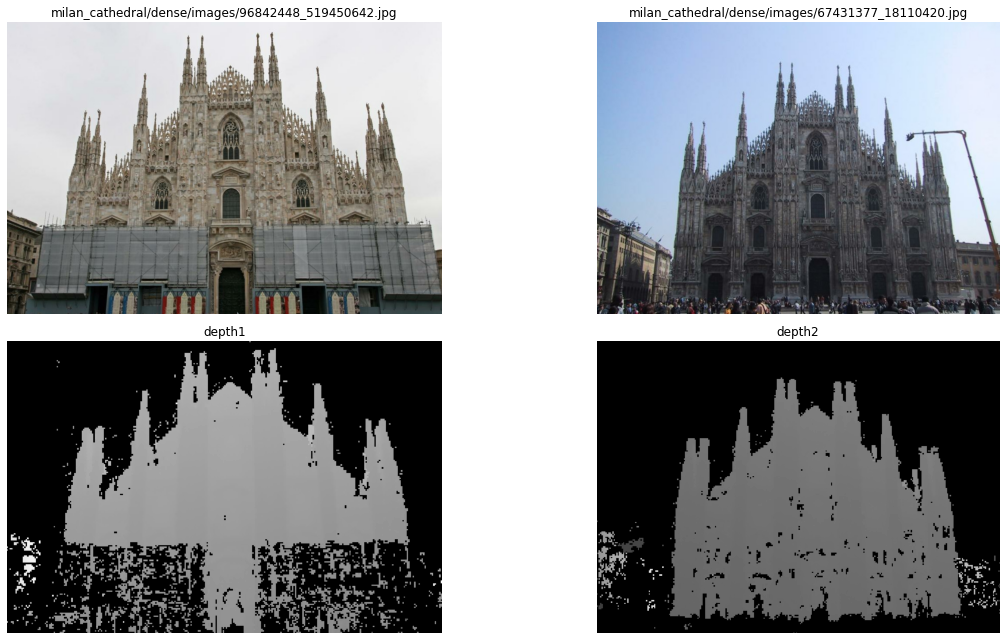

In [3]:
idx = 0

image1 = batch[du.IMAGE1]
image2 = batch[du.IMAGE2]

figures = {f"{batch[du.IMAGE_NAME1][idx]}": torch2cv(image1[idx]),
           f"{batch[du.IMAGE_NAME2][idx]}": torch2cv(image2[idx])}

if du.DEPTH1 in batch:
    figures[du.DEPTH1] = torch2cv(batch[du.DEPTH1][idx], normalize=True)
    figures[du.DEPTH2] = torch2cv(batch[du.DEPTH2][idx], normalize=True)

plot_figures(figures, len(figures) // 2, 2, (18, 9))

In [4]:
kp1 = endpoint[eu.KP1]
kp2 = endpoint[eu.KP2]

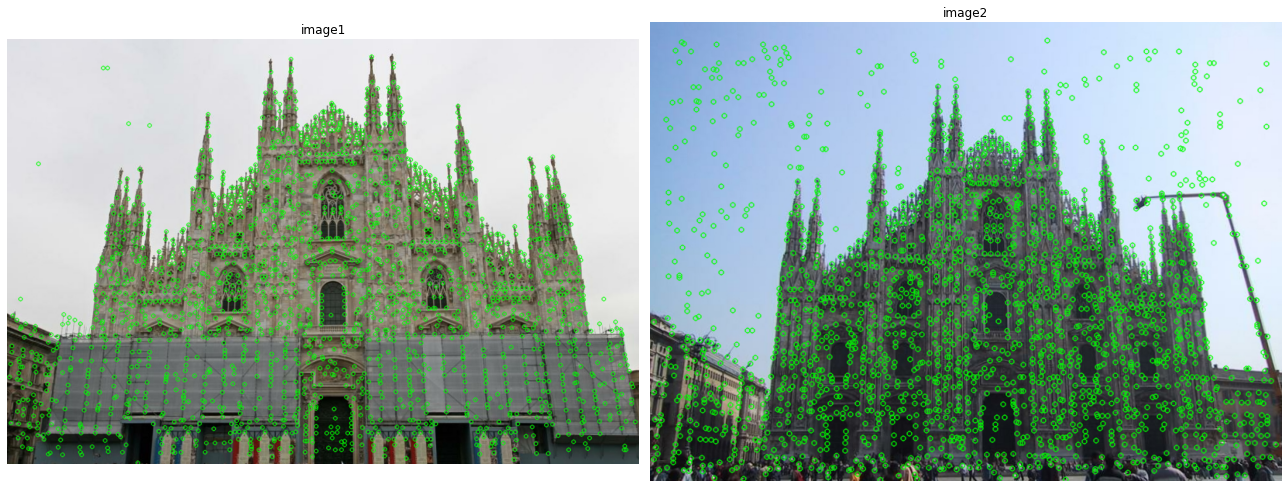

In [5]:
plot_figures({'image1': draw_cv_keypoints(image1, kp1),
              'image2': draw_cv_keypoints(image2, kp2)}, 1, 2, (18, 9))

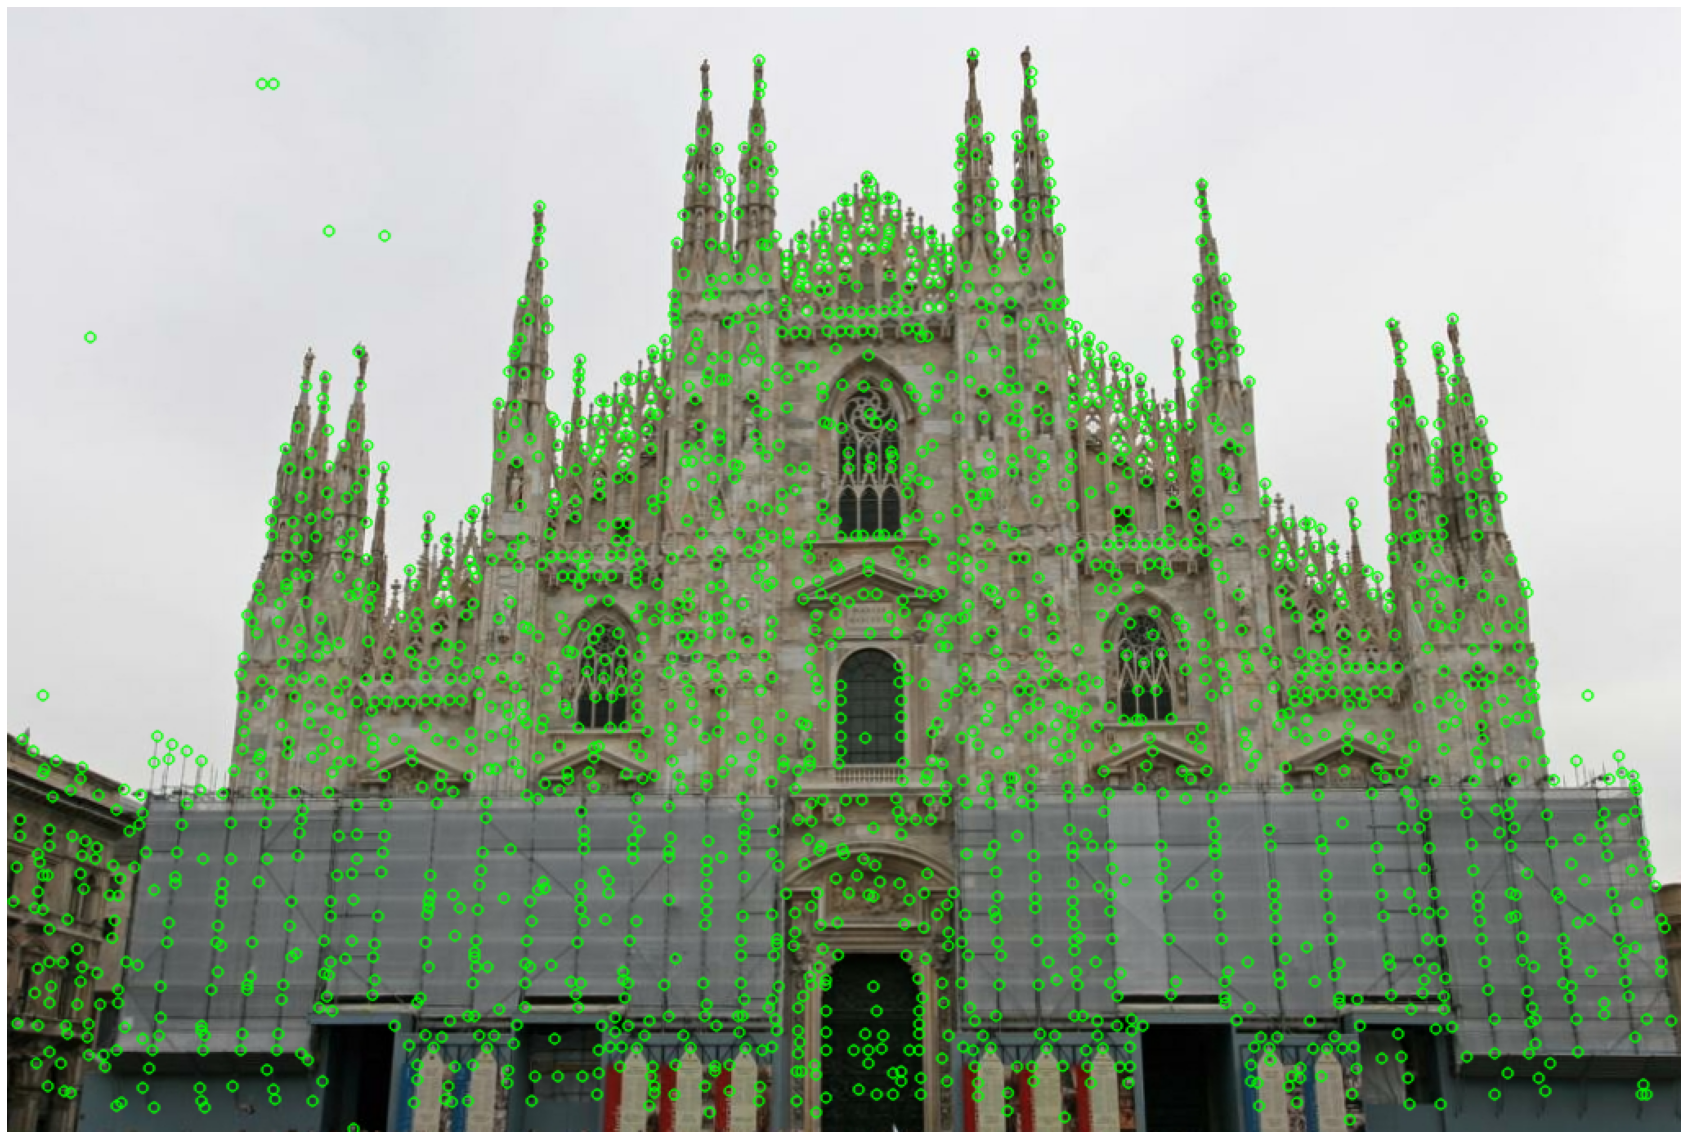

In [7]:
plt.figure(figsize =(30, 30))
plt.imshow(draw_cv_keypoints(image1, kp1))
plt.axis('off')
plt.savefig('check.png', bbox_inches='tight')

In [99]:
shift_scale1 = batch[du.SHIFT_SCALE1]
shift_scale2 = batch[du.SHIFT_SCALE2]

if du.INTRINSICS1 in batch:
    intrinsics1 = batch[du.INTRINSICS1]
    intrinsics2 = batch[du.INTRINSICS2]

    extrinsics1 = batch[du.EXTRINSICS1]
    extrinsics2 = batch[du.EXTRINSICS2]
    
if du.H1 in batch:
    h1 = batch[du.H1]

In [100]:
mme_params = experiment.main_loop.model_mode_wrapper.model_mode_eval_params

## Feature matching

In [101]:
from source.pose.matchers.factory import instantiate_matcher
from source.evaluation.utils import get_kp_desc_and_kp_desc_mask

matcher = instantiate_matcher(mme_params, experiment.device)

kp_desc1, kp_desc2, kp_desc_mask1, kp_desc_mask2 = get_kp_desc_and_kp_desc_mask(endpoint)

mm_desc_mask1, nn_desc_idx1 = matcher.match(kp_desc1, kp_desc2, kp_desc_mask1, kp_desc_mask2)

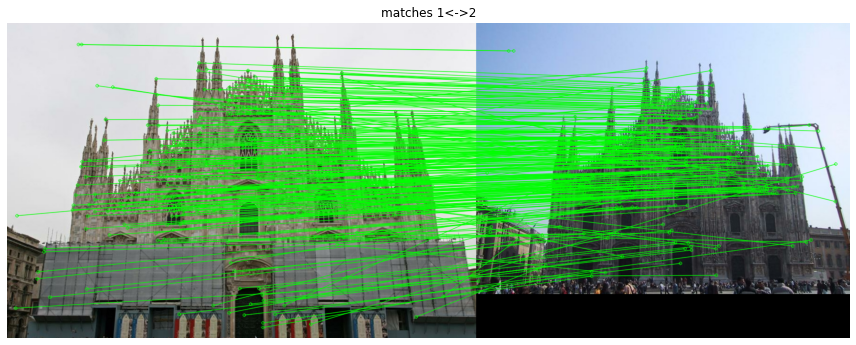

In [102]:
cv_image12_matches = draw_cv_matches(image1, image2, 
                                     kp1, kp2,
                                     nn_desc_idx1, mm_desc_mask1)

plot_figures({'matches 1<->2': cv_image12_matches}, 1, 1, (12, 10))

## Pose estimation

In [27]:
import source.pose.estimators.namespace as est_ns

from source.pose.estimators.fund_mat import FundMatEstimator
from source.pose.estimators.ess_mat import EssMatEstimator
from source.pose.estimators.homography import HomographyEstimator
from source.pose.estimators.utils import revert_shift_scale
from source.evaluation.rel_pose.metrics import relative_pose_error, relative_pose_error_from_homography
from source.pose.matchers.utils import gather_kp


_kp1, _kp2 = revert_shift_scale(endpoint[eu.KP1], shift_scale1), revert_shift_scale(endpoint[eu.KP2], shift_scale2)
nn_kp2 = gather_kp(_kp2, nn_desc_idx1.cpu())

estimator_name = mme_params.estimator.name

if estimator_name in [est_ns.F_PYDEGENSAC, est_ns.E_PYOPENGV]:
    if estimator_name == est_ns.F_PYDEGENSAC:
        estimator = FundMatEstimator.from_config(mme_params)
    
    elif estimator_name == est_ns.E_PYOPENGV:
        estimator = EssMatEstimator.from_config(mme_params)
    
    T12, inl_mask, success = estimator.estimate(_kp1[0].numpy(), nn_kp2[0].numpy(),
                                               mm_desc_mask1[0].cpu().numpy(),
                                               batch[du.INTRINSICS1][0].numpy(), batch[du.INTRINSICS2][0].numpy())
    
    r_err, t_err = relative_pose_error(T12[None], success,
                                       batch[du.EXTRINSICS1].numpy(), batch[du.EXTRINSICS2].numpy())

elif estimator_name in [est_ns.H_PYDEGENSAC, est_ns.H_OPENCV]:
    estimator = HomographyEstimator.from_config(mme_params)
    
    T12, inl_mask, success = estimator.estimate(_kp1[0].numpy(), nn_kp2[0].numpy(),
                                                mm_desc_mask1[0].cpu().numpy())
    
    r_err, t_err = relative_pose_error_from_homography(T12, inl_mask, success,
                                                       _kp1[0].numpy(), nn_kp2[0].numpy(),
                                                       batch[du.H1][0].numpy())

In [28]:
print('R err:', r_err.mean(-1).item())
print('t err:', t_err.mean(-1).item())
print("Num inliers:", inl_mask.sum(-1).mean().item())


R err: 2.1052896252514866
t err: 15.438116714339234
Num inliers: 282.0


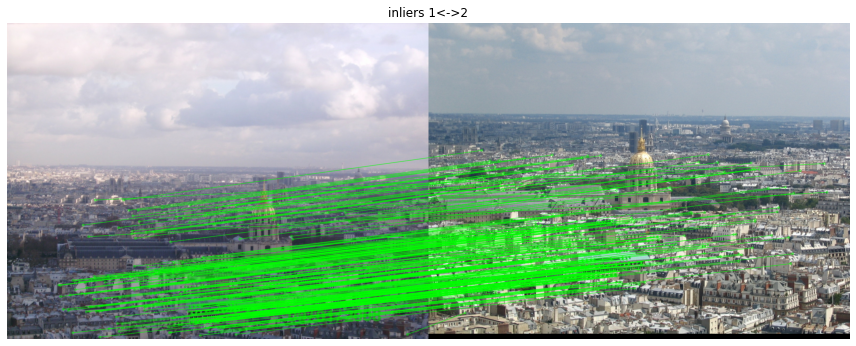

In [29]:
cv_image12_inliers = draw_cv_matches(image1, image2, 
                                     endpoint[eu.KP1], endpoint[eu.KP2], nn_desc_idx1,
                                     inl_mask[None])

plot_figures({'inliers 1<->2': cv_image12_inliers}, 1, 1, (12, 10))

## Repeatability score

In [30]:
from source.datasets.base.utils import HDataWrapper
from source.evaluation.classical.metrics import repeatability_score

if du.H1 in batch:
    h_data = HDataWrapper().init_from_batch(batch, torch.device('cpu'))
    
    rep = repeatability_score(kp1, kp2,
                              h_data,
                              torch.range(1, 10))
    
    print(rep)

## Mean matcing accuracy

In [31]:
from source.datasets.base.utils import HDataWrapper
from source.evaluation.classical.metrics import mean_matching_accuracy

if du.H1 in batch:
    h_data = HDataWrapper().init_from_batch(batch, torch.device('cpu'))
    
    mma = mean_matching_accuracy(kp1, kp2,
                                 kp_desc1, kp_desc2,
                                 kp_desc_mask1, kp_desc_mask2,
                                 matcher, h_data,
                                 torch.range(1, 10))
    
    print(mma)

## Legacy code

In [ ]:
# reproj_err, inl_mask = homography_corners_reprojection_error(_kp1, _nn_kp2,
#                                                              _mm_desc_mask1, 
#                                                              image1.shape, shift_scale1, h1,
#                                                              estimator)
# print(f"Re-proj. error: {reproj_err.mean(-1).item():.3f}")
# print("Num inliers:", inl_mask.sum(-1).mean().item())

In [ ]:
# weights = torch.load("/home/konstantin/personal/Summertime/runs/models/shiness/checkpoints/model_r_mAA=0.7706.pt")
# weights['0.unet.up_layers.3.conv.1.0.bias'] = weights['0.unet.up_layers.3.conv.1.0.bias'][None]
# weights['0.unet.up_layers.3.conv.1.0.weight'] = weights['0.unet.up_layers.3.conv.1.0.weight'][:1]
# torch.save(weights, "/home/konstantin/personal/Summertime/runs/models/shiness/checkpoints/model_r_mAA=0.7706.pt")

In [ ]:
# from source.utils.common_utils import create_coord_grid, normalize_coord
# from source.projective.utils import to_homogeneous, to_cartesian, grid_sample


# intr = torch.tensor([[1008 // 2, 0, 1008 // 2],
#                      [0, 656 // 2, 656 // 2],
#                      [0, 0, 1]]).float()

# plane = create_coord_grid(image1.shape)
# plane_edge = to_homogeneous(plane)
# plane_edge = ((intr).inverse() @ plane_edge.permute(3, 0, 1, 2).view(3, -1)).permute(1, 0)


# t = torch.tensor([[1, 0, 0, 0],
#                   [0, 1, 0, 0],
#                   [0, 0, 1, -3],
#                   [0, 0, 0, 1]]).float()

# angle = 45 / 180 * np.pi

# R1 = torch.tensor([[np.cos(angle), 0, np.sin(angle), 0],
#                    [0, 1, 0, 0],
#                    [-np.sin(angle), 0, np.cos(angle), 0],
#                    [0, 0, 0, 1]]).float()

# angle = 35.264 / 180 * np.pi

# R2 = torch.tensor([[1, 0, 0, 0],
#                    [0, np.cos(angle), np.sin(angle), 0],
#                    [0, -np.sin(angle), np.cos(angle), 0],
#                    [0, 0, 0, 1]]).float()

# rotated_plane = (t @ R2 @ R1 @ to_homogeneous(plane_edge).transpose(1, 0)).transpose(1, 0)

# rotated_plane[:, 0] *= -1
# rotated_plane[:, 1] *= -1

# projected_plane = (intr @ to_cartesian(rotated_plane).permute(1, 0)).permute(1, 0)
# projected_plane = (projected_plane[:, :2] / projected_plane[:, 2, None]).reshape(1, image1.shape[2], image1.shape[3], 2)



# from scipy.interpolate import griddata

# grid_x, grid_y = np.meshgrid(np.arange(projected_plane.shape[2]), np.arange(projected_plane.shape[1]))
# grid = np.concatenate([np.expand_dims(grid_x, -1),
#                        np.expand_dims(grid_y, -1)], axis=-1)

# output = griddata(projected_plane.numpy().reshape(-1, 2),
#                   batch[du.IMAGE_GRAY1].view(-1).numpy(),
#                   grid.reshape(-1, 2), method='linear', fill_value=0)
# plot_figures({'b': torch2cv(torch.tensor(output.reshape(1, 656, 1008)))},
#              1, 1, (12, 12))
# points3D = np.stack([[-1.0, -1.0, 1., 1],
#                     [-1.0, 1.0, 1, 1.],
#                     [1.0, 1.0, 1, 1.],
#                     [1.0, -1.0, 1., 1.]], axis=0)

# angle = 45 / 180 * np.pi

# R1 = np.array([[np.cos(angle), 0, np.sin(angle), 0],
#                 [0, 1, 0, 0],
#                 [-np.sin(angle), 0, np.cos(angle), 0],
#                 [0, 0, 0, 1]])

# angle = 35.264 / 180 * np.pi

# R2 = np.array([[1, 0, 0, 0],
#                [0, np.cos(angle), np.sin(angle), 0],
#                [0, -np.sin(angle), np.cos(angle), 0],
#                [0, 0, 0, 1]])

# t = np.array([[1, 0, 0, 0],
#               [0, 1, 0, 0],
#               [0, 0, 1, -3],
#               [0, 0, 0, 1]])

# rotated_points3D = (t @ R2 @ R1 @ points3D.transpose(1, 0)).transpose(1, 0)

# print(rotated_points3D)

# points1 = points3D[:, :2]
# points2 = rotated_points3D[:, :2] / rotated_points3D[:, 2, None]
# points2[:, 0] *= -1
# points2[:, 1] *= -1

# intr = np.expand_dims((1008 // 2, 656 // 2), axis=0)

# points1 = points1 * intr + intr
# points2 = points2 * intr + intr
# def ax(p, q):
#     return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]

# def ay(p, q):
#     return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

# a_mat = np.stack([f(points1[i], points2[i]) for i in range(4) for f in (ax, ay)], axis=0)
# p_mat = np.transpose(np.stack([[points2[i][j] for i in range(4) for j in range(2)]], axis=0))

# homography = np.transpose(np.linalg.lstsq(a_mat, p_mat, rcond=None)[0])
# homography = np.reshape(np.concatenate([homography, np.ones([homography.shape[0], 1])], axis=1), [3, 3])
# from source.datasets.base.utils import HDataWrapper
# from source.projective.warp import warp_image

# tr = torch.tensor(homography).float().unsqueeze(0)

# hdata = HDataWrapper().init_from_batch({'h1': tr, 
#                                         'h2': tr.inverse(),
#                                         'image_shape1': image1.shape,
#                                         'image_shape2': image1.shape,
#                                         'shift_scale1': torch.tensor([[0, 0, 1, 1]]),
#                                         'shift_scale2': torch.tensor([[0, 0, 1, 1]])}, torch.device('cpu'))

# plot_figures({'b': torch2cv(warp_image(image1, hdata, 'i')[0])},
#              1, 1, (12, 12))

In [ ]:
# import shutil

# base_path = "../runs/train/dohness/filtering/"

# for f in os.listdir(base_path):
#     checkpoints_path = os.path.join(base_path, f, 'checkpoints')
    
#     for c in os.listdir(checkpoints_path):
#         if '_save' in c:
#             os.remove(os.path.join(checkpoints_path, c))
            
#             shutil.copyfile(os.path.join(checkpoints_path, c), os.path.join(checkpoints_path, c + '_save'))
#             model = torch.load(os.path.join(checkpoints_path, c))
            
#             model['0.unet.up_layers.3.conv.1.0.weight'] = model['0.unet.up_layers.3.conv.1.0.weight'][None, 0]
#             model['0.unet.up_layers.3.conv.1.0.bias'] = model['0.unet.up_layers.3.conv.1.0.bias'][None, 0]
            
#             torch.save(model, os.path.join(checkpoints_path, c))

# model = torch.load("../runs/models/shiness/checkpoints/model_r_mAA=0.7706.pt")

# model['0.unet.up_layers.3.conv.1.0.weight'] = model['0.unet.up_layers.3.conv.1.0.weight'][None, 0]
# model['0.unet.up_layers.3.conv.1.0.bias'] = model['0.unet.up_layers.3.conv.1.0.bias'][None, 0]

# torch.save(model, "../runs/models/shiness/checkpoints/model_r_mAA=0.77065.pt")

In [125]:
# from source.pose.estimators.abs_pose import AbsPoseEstimatorOpenGV
# from source.pose.utils import prepare_abs_pose_input
# from source.evaluation.rel_pose.metrics import absolute_pose_error

# abs_pose_estimator = AbsPoseEstimatorOpenGV(0.3)

# _world_kp1, _nn_kp2, _mm_desc_mask1, _intrinsics2 = prepare_abs_pose_input(kp1, kp2,
#                                                                            depth1,
#                                                                            nn_desc_idx1, mm_desc_mask1,
#                                                                            intrinsics1, intrinsics2,
#                                                                            shift_scale1, shift_scale2)

# r_err, t_l2_err, t_ang_err, inl_mask = absolute_pose_error(_world_kp1, _nn_kp2,
#                                                            _mm_desc_mask1,
#                                                            _intrinsics2,
#                                                            extrinsics1.numpy(), extrinsics2.numpy(),
#                                                            abs_pose_estimator)

In [126]:
# print('R err:', r_err.mean(-1).item())
# print('t L2 err:', t_l2_err.mean(-1).item())
# print('t ang err:', t_ang_err.mean(-1).item())
# print("Num inliers:", inl_mask.sum(-1).mean().item())

In [127]:
# cv_image12_inliers = draw_cv_matches(image1, image2, 
#                                      kp1, kp2, nn_desc_idx1,
#                                      inl_mask[:, r_err.argmin(axis=-1).item(), :], batch_id=idx)

# plot_figures({'inliers 1<->2': cv_image12_inliers})

In [128]:
# from source.projective.rbt import pointcloudify_depth_and_project
# from source.projective.utils import to_homogeneous_pose
# from source.evaluation.rel_pose.vis import plot_projected_pcd

# rel_pose, inl_mask = abs_pose_estimator.estimate(_world_kp1, _nn_kp2,
#                                                  _mm_desc_mask1,
#                                                  _intrinsics2)

# proj_grid1, world_grid_depth1 = pointcloudify_depth_and_project(image1, depth1,
#                                                                 intrinsics1, shift_scale1,
#                                                                 intrinsics2, to_homogeneous_pose(rel_pose[:, 0]), shift_scale2)

# plot_projected_pcd(image2, proj_grid1, world_grid_depth1)

In [129]:
### Absolute pose estimation. G2O

In [130]:
# from source.pose.estimators.abs_pose import AbsPoseEstimatorG2O
# from source.pose.utils import prepare_abs_pose_input
# from source.evaluation.rel_pose.metrics import absolute_pose_error

# abs_pose_estimator = AbsPoseEstimatorG2O()


# _world_kp1, _nn_kp2, _mm_desc_mask1, _intrinsics2 = prepare_abs_pose_input(kp1, kp2,
#                                                                            depth1,
#                                                                            nn_desc_idx1, mm_desc_mask1,
#                                                                            intrinsics1, intrinsics2,
#                                                                            shift_scale1, shift_scale2)

# r_err, t_l2_err, t_ang_err, inl_mask = absolute_pose_error(_world_kp1, _nn_kp2,
#                                                            _mm_desc_mask1,
#                                                            _intrinsics2,
#                                                            extrinsics1.numpy(), extrinsics2.numpy(),
#                                                            abs_pose_estimator)

In [131]:
# print('R err:', r_err.mean(-1).item())
# print('t L2 err:', t_l2_err.mean(-1).item())
# print('t ang err:', t_ang_err.mean(-1).item())
# print("Num inliers:", inl_mask.sum(-1).mean().item())

In [132]:
# cv_image12_inliers = draw_cv_matches(image1, image2, 
#                                      kp1, kp2, nn_desc_idx1,
#                                      inl_mask[:, r_err.argmin(axis=-1).item(), :], batch_id=idx)

# plot_figures({'inliers 1<->2': cv_image12_inliers})

In [133]:
# from source.projective.rbt import pointcloudify_depth_and_project
# from source.projective.utils import to_homogeneous_pose
# from source.evaluation.rel_pose.vis import plot_projected_pcd

# rel_pose, inl_mask = abs_pose_estimator.estimate(_world_kp1, _nn_kp2,
#                                                  _mm_desc_mask1,
#                                                  _intrinsics2)

# proj_grid1, world_grid_depth1 = pointcloudify_depth_and_project(image1, depth1,
#                                                                 intrinsics1, shift_scale1,
#                                                                 intrinsics2, to_homogeneous_pose(rel_pose[:, 0]), shift_scale2)

# plot_projected_pcd(image2, proj_grid1, world_grid_depth1)

In [139]:
# from source.pose.abs_pose_estimator import AbsPoseEstimatorG2O
# from source.evaluation.rel_pose.metrics import relative_pose_with_scale_error

# abs_pose_estimator = AbsPoseEstimatorG2O()

# num_repeats = 1

# r_err, t_l2_err, t_ang_err, inl_mask = relative_pose_with_scale_error(kp1, kp2,
#                                                                       kp_desc1, kp_desc2,
#                                                                       depth1,
#                                                                       shift_scale1, shift_scale2,
#                                                                       intrinsics1, intrinsics2,
#                                                                       extrinsics1, extrinsics2,
#                                                                       matcher, abs_pose_estimator)

In [140]:
# print('R err:', r_err.item())
# print('t L2 err:', t_l2_err.item())
# print('t ang err:', t_ang_err.item())
# print("Num inliers:", inl_mask.sum(-1).mean().item())

In [141]:
# cv_image12_inliers = draw_cv_matches(image1, image2, 
#                                      kp1, kp2, nn_desc_idx1,
#                                      inl_mask[:, 0], batch_id=idx)

# plot_figures({'inliers 1<->2': cv_image12_inliers})

In [142]:
# from source.pose.abs_pose_estimator import AbsPoseEstimatorOpenGV

# abs_pose_estimator = AbsPoseEstimatorOpenGV(1.0)

# num_repeats = 10

# r_err, t_l2_err, t_ang_err, inl_mask = relative_pose_with_scale_error(kp1, kp2,
#                                                                       kp_desc1, kp_desc2,
#                                                                       depth1,
#                                                                       shift_scale1, shift_scale2,
#                                                                       intrinsics1, intrinsics2,
#                                                                       extrinsics1, extrinsics2,
#                                                                       matcher, abs_pose_estimator, 
#                                                                       num_repeats)

In [143]:
# print('R err:', r_err.mean(-1).item())
# print('t L2 err:', t_l2_err.mean(-1).item())
# print('t ang err:', t_ang_err.mean(-1).item())
# print("Num inliers:", inl_mask.sum(-1).mean().item())

In [52]:
# cv_image12_inliers = draw_cv_matches(image1, image2, 
#                                      kp1, kp2, nn_desc_idx1,
#                                      inl_mask[:, r_err.argmin(axis=-1).item(), :], batch_id=idx)

# plot_figures({'inliers 1<->2': cv_image12_inliers})

In [55]:
# err1, err2 = endpoint[eu.ERR1].to(experiment.device), \
#             endpoint[eu.ERR2].to(experiment.device)

# plot_figures({'a': torch2cv((-err1[0]).exp()),
#               'b': torch2cv((-err2[0]).exp())}, 1, 2, (18, 9))

# from source.nn.devl.utils.endpoint_utils import get_e_err
# from source.utils.endpoint_utils import nms